# 🩺 NLP Médical – Pipeline complet avec transcription + classification + NER + résumé
Ce notebook réalise :
- La transcription d'un audio médical
- Le fine-tuning de CamemBERT sur un jeu de données de classification médicale
- La classification du thème
- L'extraction d'entités médicales (NER)
- Le résumé automatique du texte

**⚠️ Remarque** : ce notebook est prévu pour être exécuté sur Google Colab (GPU recommandé pour l'entraînement).

In [ ]:
# 📦 Étape 0 – Installation des dépendances
!pip install -q transformers datasets torchaudio librosa sentencepiece gradio #scikit-learn
!pip install --upgrade transformers
!pip install huggingface_hub --upgrade

In [4]:
# 📁 Étape 1 – Charger le dataset de classification médicale
import pandas as pd
df = pd.read_csv("medical_dataset.csv")
df.head()

,text,label,label_id
0,Le patient souffre d'hypertension et doit surv...,cardio,0
1,On note une tachycardie persistante suite à un...,cardio,0
2,Le patient est très stressé souffre de trouble...,psy,1
3,La dépression est diagnostiquée depuis plusieu...,psy,1
4,La glycémie est instable malgré le traitement ...,diabete,2


In [9]:
import pandas as pd

# Ton jeu de données original
df_orig = pd.read_csv("medical_dataset.csv")

# Données enrichies simulées
data_new = [
    ("Le patient présente une arythmie et des douleurs thoraciques.", "cardio", 0),
    ("Un souffle cardiaque est détecté à l’auscultation.", "cardio", 0),
    ("On observe une bradycardie persistante chez le patient.", "cardio", 0),
    ("Le patient est sujet à des attaques de panique fréquentes.", "psy", 1),
    ("Il rapporte des troubles de concentration et une humeur dépressive.", "psy", 1),
    ("Des signes de schizophrénie ont été détectés au cours de l’entretien.", "psy", 1),
    ("La patiente suit un traitement à l’insuline pour contrôler son diabète.", "diabete", 2),
    ("Une hypoglycémie sévère a été observée après l’effort physique.", "diabete", 2),
    ("Le taux de sucre dans le sang reste élevé malgré le régime adapté.", "diabete", 2),
    ("Le patient souffre d’une crise cardiaque survenue à son domicile.", "cardio", 0),
    ("Il a consulté pour des idées suicidaires persistantes.", "psy", 1),
    ("Un nouveau traitement oral est prescrit pour le diabète de type 1.", "diabete", 2)
]

df_new = pd.DataFrame(data_new, columns=["text", "label", "label_id"])

# Fusionner
df_total = pd.concat([df_orig, df_new], ignore_index=True)
df_total.to_csv("medical_dataset_enriched.csv", index=False)

df_total.to_csv("base_medicale_etendue_.csv", index=False)



In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Charger le dataset
#df = pd.read_csv("medical_dataset.csv")

# Vérifie les colonnes
#print(df.head())

# Map labels string vers entiers
label2id = {"cardio": 0, "psy": 1, "diabete": 2}
df_total['label'] = df_total['label'].map(label2id)

# Convertir en Dataset Hugging Face
dataset = Dataset.from_pandas(df_total)

# Split train/test
dataset = dataset.train_test_split(test_size=0.3, seed=42)

print(dataset['train'].to_pandas()['label'].value_counts())
print(dataset['test'].to_pandas()['label'].value_counts())

# Tokenizer CamemBERT
tokenizer = AutoTokenizer.from_pretrained("camembert-base")

def preprocess(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(preprocess, batched=True)

# Charger modèle CamemBERT pour classification 3 classes
model = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=3)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=5e-5,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted", zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)

# Entraînement
trainer.train()


# Sauvegarder modèle et tokenizer
trainer.save_model("./results")
tokenizer.save_pretrained("./results")


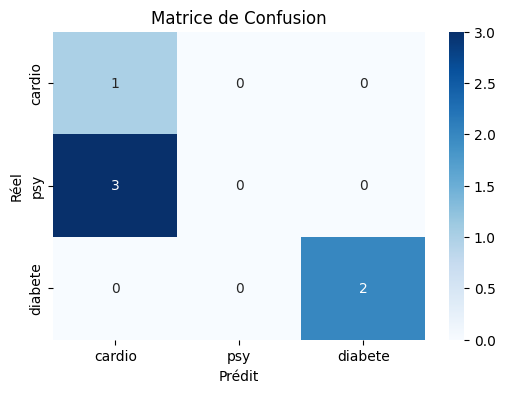

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
# Prédictions
preds_output = trainer.predict(encoded_dataset['test'])
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
labels = ['cardio', 'psy', 'diabete']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

In [19]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Charger modèle et processeur Whisper
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

# Choisir device : GPU si dispo, sinon CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Charger audio (à uploader sur Colab)
audio_path = "diabete_3.mp3"
waveform, sr = torchaudio.load(audio_path)

# Resample à 16 kHz (format attendu)
waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform).squeeze()

# Préparer les inputs avec padding et attention mask
inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Générer la transcription
with torch.no_grad():
    generated_ids = model.generate(
        inputs["input_features"],
        attention_mask=inputs.get("attention_mask", None),
        language="fr",
        task="transcribe"
    )

# Décoder la sortie en texte
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("📄 Transcription :", transcription)
print("Device utilisé :", device)


📄 Transcription :  Bonjour, Monsieur Dupont est atteint de diabète type 2 depuis 10 ans. Il présente une glisse et m'a l'équilibré malgré un traitement par metformine. Il se plaint de fatigue persistante et de piquotement dans les pieds. Son alimentation déséquilibrée, il a du mal à suivre les recommandations diététiques. Là, c'est le jour où il faut tout le monde se mobilise. C'est un cas critique. Il faut être pressé. Merci.
Device utilisé : cpu


In [20]:
# 🩺 Étape 4 – Classification du thème médical avec le modèle entraîné
from transformers import pipeline, AutoModelForSequenceClassification

model_cls = AutoModelForSequenceClassification.from_pretrained("./results")
classifier = pipeline("text-classification", model=model_cls, tokenizer=tokenizer, return_all_scores=True)

# Appliquer la classification sur la transcription
all_scores = classifier(transcription)

# Affichage des scores pour chaque classe
print("🩺 Scores des thèmes médicaux détectés :")
for score in all_scores[0]:
    print(f"{score['label']}: {round(score['score']*100, 2)} %")


Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


🩺 Scores des thèmes médicaux détectés :
LABEL_0: 38.0 %
LABEL_1: 28.83 %
LABEL_2: 33.17 %


In [9]:
#!pip install huggingface_hub --upgrade

In [28]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `NLP` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `NLP`


In [29]:
from huggingface_hub import HfApi

api = HfApi()
user = api.whoami()
print("Connecté en tant que :", user['name'])


Connecté en tant que : waelbensoltana


In [ ]:
# 📁 Chargement du modèle NER médical français
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained("Thibeb/DrBert_generalized")
model = AutoModelForTokenClassification.from_pretrained("Thibeb/DrBert_generalized")

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 📄 Charger ta base (fichier CSV ou dataframe si déjà en mémoire)
df = pd.read_csv("medical_dataset_enriched.csv")  # ou ton fichier local

# 🔍 Appliquer le NER à chaque ligne du texte
def extract_entities(text):
    entities = ner_pipeline(text)
    return [(ent['word'], ent['entity_group']) for ent in entities]

df["entities"] = df["text"].apply(extract_entities)

# 🔎 Afficher quelques résultats
print(df[["text", "entities"]].head(10))

# 💾 Optionnel : sauvegarde dans un nouveau fichier CSV
df.to_csv("medical_dataset_with_entities_.csv", index=False)


In [37]:
transcription2 = "Bonjour, le patient présente une douleur et un diabète de type 2 non contrôlé avec une glycémie élevée et prend de la metformine."
print(transcription2)
entities = ner_pipeline(transcription2)

for ent in entities:
    print(ent)


Bonjour, le patient présente une douleur et un diabète de type 2 non contrôlé avec une glycémie élevée et prend de la metformine.
{'entity_group': 'DISO', 'score': np.float32(0.97911435), 'word': 'do', 'start': 33, 'end': 35}
{'entity_group': 'DISO', 'score': np.float32(0.7758536), 'word': '##uleur', 'start': 35, 'end': 40}
{'entity_group': 'DISO', 'score': np.float32(0.8926427), 'word': 'diabete de type 2', 'start': 47, 'end': 64}
{'entity_group': 'DISO', 'score': np.float32(0.7836244), 'word': 'glycemie elevee', 'start': 87, 'end': 102}
{'entity_group': 'CHEM', 'score': np.float32(0.9229401), 'word': 'metformin', 'start': 118, 'end': 127}


In [15]:
# ✂️ Étape 6 – Résumé automatique du texte
summarizer = pipeline("summarization", model="plguillou/t5-base-fr-sum-cnndm")
resume = summarizer(transcription, max_length=100, min_length=20, do_sample=False)[0]['summary_text']
print("📝 Résumé :", resume)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0
Your max_length is set to 100, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


📝 Résumé : M. DuPont a tit to Diabet for 10 years. Son blood sugar levels remain poor, he controlled his blood treatment with metformin. During the consultation his blood pressure is high and his BME indicates he has diabetes.
